In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.stats import norm
from datetime import datetime, timedelta

In [3]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.stats import norm
from datetime import datetime, timedelta

class OptionsAnalyzer:
    def __init__(self, ticker_symbol='^GSPC', time_frame='6mo'):
        self.ticker_symbol = ticker_symbol
        self.time_frame = time_frame
        self.rf_rate = 0.05  # 5% risk-free rate
        self.market_data = None
        self.available_options = None
        
    def get_market_data(self):
        """Fetch historical price data and options chain"""
        # Get historical data
        stock = yf.Ticker(self.ticker_symbol)
        self.market_data = stock.history(period=self.time_frame)
        
        # Calculate historical volatility (using daily returns)
        daily_returns = np.log(self.market_data['Close'] / self.market_data['Close'].shift(1))
        self.vol = daily_returns.std() * np.sqrt(252)  # Annualized
        
        # Get options chain
        self.available_options = stock.options
        return self.market_data
    
    def calculate_option_price(self, asset_price, strike, time_to_exp, rate, volatility, contract_type="call"):
        """Calculate option price using Black-Scholes formula"""
        d1 = (np.log(asset_price / strike) + (rate + 0.5 * volatility ** 2) * time_to_exp) / (volatility * np.sqrt(time_to_exp))
        d2 = d1 - volatility * np.sqrt(time_to_exp)
        
        if contract_type == "call":
            price = asset_price * norm.cdf(d1) - strike * np.exp(-rate * time_to_exp) * norm.cdf(d2)
        else:  # put
            price = strike * np.exp(-rate * time_to_exp) * norm.cdf(-d2) - asset_price * norm.cdf(-d1)
        return price
    
    def compute_sensitivities(self, asset_price, strike, time_to_exp, rate, volatility):
        """Calculate option sensitivities (Greeks)"""
        d1 = (np.log(asset_price / strike) + (rate + 0.5 * volatility ** 2) * time_to_exp) / (volatility * np.sqrt(time_to_exp))
        d2 = d1 - volatility * np.sqrt(time_to_exp)
        
        sensitivities = {
            'call_delta': norm.cdf(d1),
            'put_delta': -norm.cdf(-d1),
            'gamma': norm.pdf(d1) / (asset_price * volatility * np.sqrt(time_to_exp)),
            'vega': asset_price * np.sqrt(time_to_exp) * norm.pdf(d1) / 100,  # Divided by 100 for percentage
            'call_theta': (-asset_price * norm.pdf(d1) * volatility / (2 * np.sqrt(time_to_exp)) -
                          rate * strike * np.exp(-rate * time_to_exp) * norm.cdf(d2)) / 365,  # Daily theta
            'put_theta': (-asset_price * norm.pdf(d1) * volatility / (2 * np.sqrt(time_to_exp)) +
                         rate * strike * np.exp(-rate * time_to_exp) * norm.cdf(-d2)) / 365,
            'call_rho': strike * time_to_exp * np.exp(-rate * time_to_exp) * norm.cdf(d2) / 100,
            'put_rho': -strike * time_to_exp * np.exp(-rate * time_to_exp) * norm.cdf(-d2) / 100
        }
        return sensitivities
    
    def visualize_metrics(self):
        """Generate visualization of option prices and Greeks"""
        if self.market_data is None:
            self.get_market_data()
            
        # Current price and strike range
        current_price = self.market_data['Close'].iloc[-1]
        strike_prices = np.linspace(current_price * 0.8, current_price * 1.2, 100)
        
        # Calculate theoretical prices and Greeks
        expiry = 0.5  # 6 months
        call_prices = []
        put_prices = []
        sensitivity_data = []
        
        for strike in strike_prices:
            call = self.calculate_option_price(current_price, strike, expiry, self.rf_rate, self.vol, "call")
            put = self.calculate_option_price(current_price, strike, expiry, self.rf_rate, self.vol, "put")
            sensitivity = self.compute_sensitivities(current_price, strike, expiry, self.rf_rate, self.vol)
            
            call_prices.append(call)
            put_prices.append(put)
            sensitivity_data.append(sensitivity)
        
        # Create plots
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
        
        # Plot 1: Option Prices
        ax1.plot(strike_prices, call_prices, 'b-', label='Theoretical Call')
        ax1.plot(strike_prices, put_prices, 'r-', label='Theoretical Put')
        ax1.set_title('Option Prices')
        ax1.set_xlabel('Strike Price')
        ax1.set_ylabel('Option Price')
        ax1.legend()
        ax1.grid(True)
        
        # Plot 2: Delta
        call_deltas = [g['call_delta'] for g in sensitivity_data]
        put_deltas = [g['put_delta'] for g in sensitivity_data]
        ax2.plot(strike_prices, call_deltas, 'b-', label='Call Delta')
        ax2.plot(strike_prices, put_deltas, 'r-', label='Put Delta')
        ax2.set_title('Delta')
        ax2.set_xlabel('Strike Price')
        ax2.set_ylabel('Delta')
        ax2.legend()
        ax2.grid(True)
        
        # Plot 3: Gamma and Vega
        gammas = [g['gamma'] for g in sensitivity_data]
        vegas = [g['vega'] for g in sensitivity_data]
        ax3.plot(strike_prices, gammas, 'g-', label='Gamma')
        ax3.plot(strike_prices, vegas, 'y-', label='Vega')
        ax3.set_title('Gamma and Vega')
        ax3.set_xlabel('Strike Price')
        ax3.set_ylabel('Value')
        ax3.legend()
        ax3.grid(True)
        
        # Plot 4: Theta
        call_thetas = [g['call_theta'] for g in sensitivity_data]
        put_thetas = [g['put_theta'] for g in sensitivity_data]
        ax4.plot(strike_prices, call_thetas, 'b-', label='Call Theta')
        ax4.plot(strike_prices, put_thetas, 'r-', label='Put Theta')
        ax4.set_title('Theta')
        ax4.set_xlabel('Strike Price')
        ax4.set_ylabel('Theta')
        ax4.legend()
        ax4.grid(True)
        
        plt.tight_layout()
        return fig

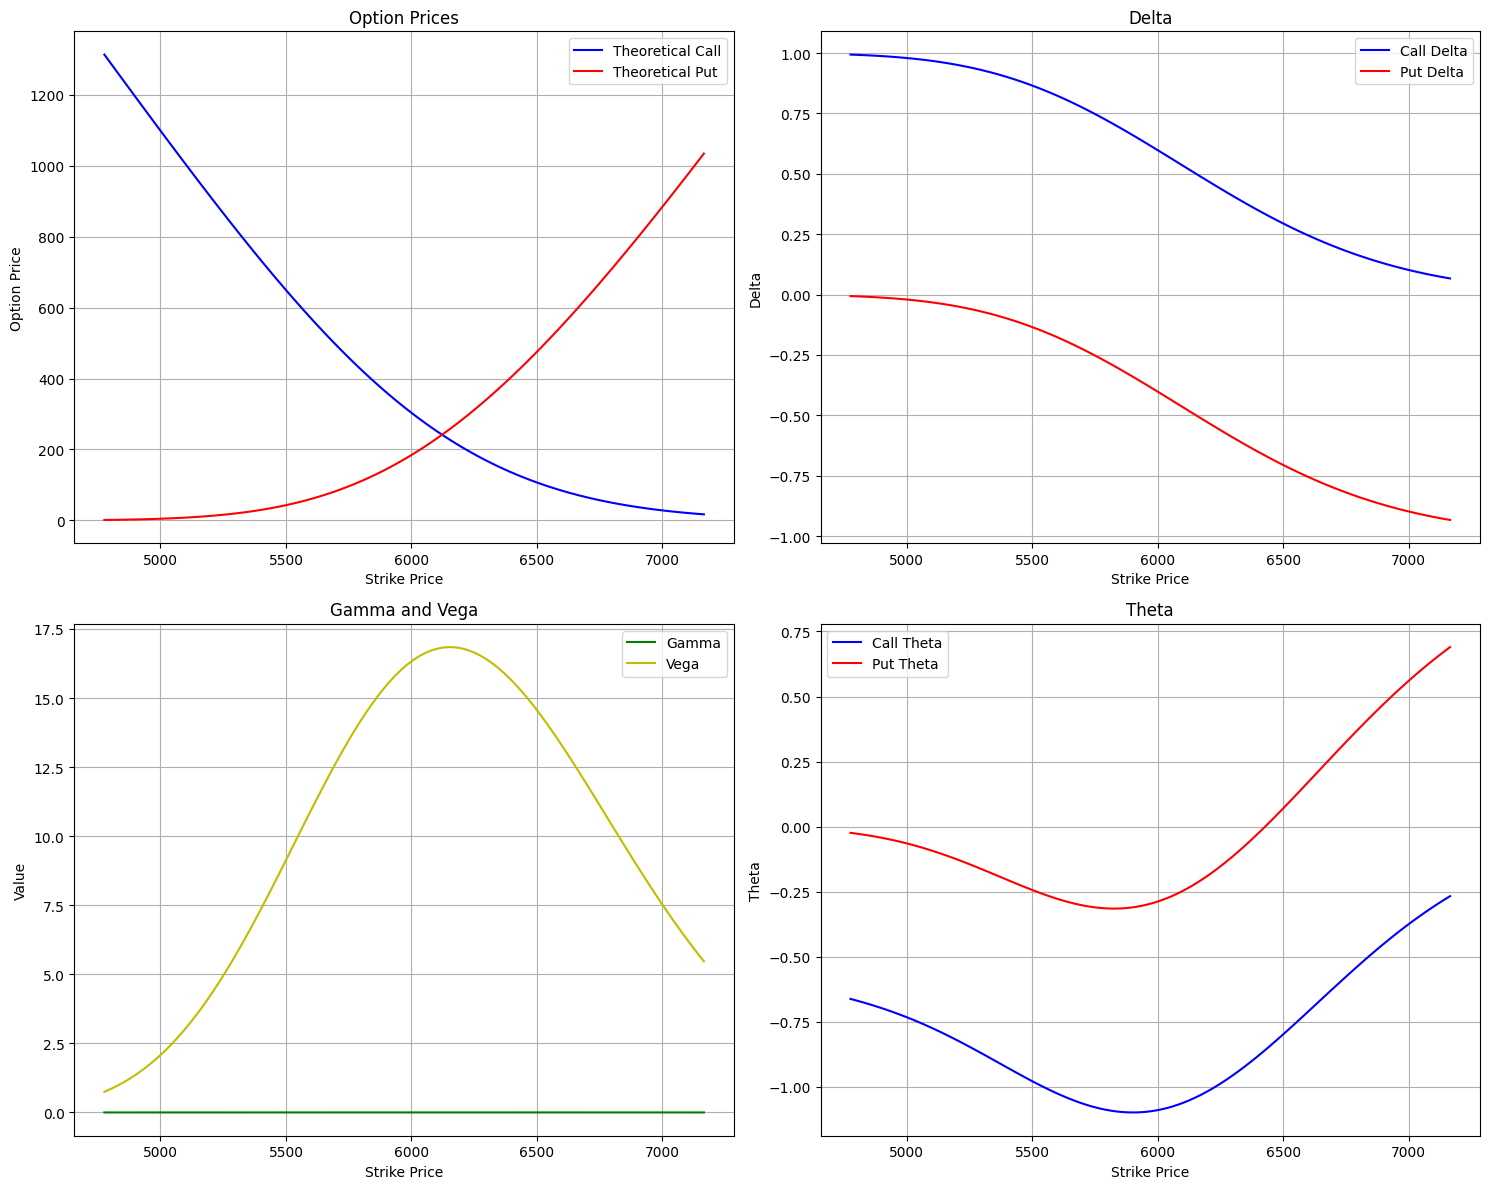


Calculations for ATM options (S = K = 5970.84):
Call Price: 319.52
Put Price: 172.10

Sensitivities (Greeks):
call_delta: 0.6168
put_delta: -0.3832
gamma: 0.0006
vega: 16.1161
call_theta: -1.0943
put_theta: -0.2966
call_rho: 16.8168
put_rho: -12.3003


In [4]:
# Example usage
analyzer = OptionsAnalyzer()
market_data = analyzer.get_market_data()
fig = analyzer.visualize_metrics()
plt.show()

# Print sample calculations for ATM options
current_price = market_data['Close'].iloc[-1]
strike = current_price  # At-the-money
expiry = 0.5
sensitivities = analyzer.compute_sensitivities(current_price, strike, expiry, analyzer.rf_rate, analyzer.vol)

print(f"\nCalculations for ATM options (S = K = {current_price:.2f}):")
print(f"Call Price: {analyzer.calculate_option_price(current_price, strike, expiry, analyzer.rf_rate, analyzer.vol, 'call'):.2f}")
print(f"Put Price: {analyzer.calculate_option_price(current_price, strike, expiry, analyzer.rf_rate, analyzer.vol, 'put'):.2f}")
print("\nSensitivities (Greeks):")
for metric, value in sensitivities.items():
    print(f"{metric}: {value:.4f}")